This code works through the GEDI subsetter version 0.6.0. This converts a geojson of tiles over a study area to temp geojson files to feed into the subsetter

In [21]:
#Open the MAAP host
from maap.maap import MAAP
maap = MAAP(maap_host='api.maap-project.org')


In [22]:
#pip install geopandas
#pip install shapely
#Import numpy for making column inputs easier
import numpy as np
import geopandas as gpd
import shapely
import glob
import os

In [23]:
#Load in AOI (This is Abigail visually checking)
aoi = gpd.read_file("https://maap-ops-workspace.s3.amazonaws.com/shared/abarenblitt/GGNPBorder.geojson")
aoi

,WDPAID,WDPA_PID,PA_DEF,NAME,ORIG_NAME,DESIG,DESIG_ENG,DESIG_TYPE,IUCN_CAT,INT_CRIT,...,MANG_AUTH,MANG_PLAN,VERIF,METADATAID,SUB_LOC,PARENT_ISO,ISO3,SUPP_INFO,CONS_OBJ,geometry
0,555548871.0,555548871,1,Tchabal Mbabo,Tchabal Mbabo,Parc National,National Park,National,II,Not Applicable,...,State,No,State Verified,1957,CM-AD,CMR,CMR,Not Applicable,Not Applicable,"MULTIPOLYGON (((11.87417 7.09244, 11.88063 7.1..."
1,7873.0,7873,1,Gashaka-Gumti,Gashaka-Gumti,National Park,National Park,National,II,Not Applicable,...,Not Reported,Not Reported,State Verified,2002,NG-TA,NGA,NGA,Not Applicable,Not Applicable,"MULTIPOLYGON (((11.88185 7.32368, 11.88161 7.3..."


<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

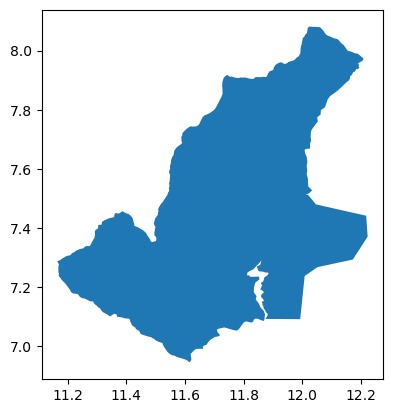

In [24]:
aoi.plot()
aoi.crs

In [25]:
import xml.etree.ElementTree as ET
from urllib.parse import urlparse

def job_status_for(job_id: str) -> str:
    response = maap.getJobStatus(job_id)
    response.raise_for_status()
    
    root = ET.fromstring(response.text)
    status_element = root.find('.//{http://www.opengis.net/wps/2.0}Status')
    
    return status_element.text

def job_result_for(job_id: str) -> str:
    response = maap.getJobResult(job_id)
    response.raise_for_status()
    
    root = ET.fromstring(response.text)

    return root.find('.//{http://www.opengis.net/wps/2.0}Data').text

def to_job_output_dir(job_result_url: str) -> str:
    url_path = urlparse(job_result_url).path
    # The S3 Key is the URL path excluding the `/{username}` prefix
    s3_key = "/".join(url_path.split("/")[2:])

    return f"/projects/my-private-bucket/{s3_key}"

In [26]:
#Needed For L2B
#Create empty variables to fill with all 29 appearances of cover_z* and pai_z* 
variables = []
for n in np.arange(0, 30,1):
    variables.append('cover_z' + str(n))
    variables.append('pai_z' + str(n))

In [30]:
AOIS = ["https://maap-ops-workspace.s3.amazonaws.com/shared/abarenblitt/GGNPBorder.geojson"]
PRODUCTS = ["L4A","L2A","L2B"]
#PRODUCTS = ["L2B"]
print(AOIS)
#print(each_aoi)
os.path.basename(each_aoi).split('.')[0] + "_L2A.gpkg"

['https://maap-ops-workspace.s3.amazonaws.com/shared/abarenblitt/GGNPBorder.geojson']


'GGNPBorder_L2A.gpkg'

In [31]:
#Set up run to pull products for all GEDI products simultaneously
#To run for only 1 or 2 products, change "PRODUCTS"

for each_aoi in AOIS: 
    if "L4A" in PRODUCTS: 
        print("Thanks, I'll run the GEDI L4A subsetter!!")
        aoi_url = each_aoi
        inputs = dict(
           aoi=aoi_url,
           doi="L4A",
           lat="lat_lowestmode",
           lon="lon_lowestmode",
           beams="all",
           columns="shot_number,lat_lowestmode,lon_lowestmode,agbd,agbd_se,agbd_t,agbd_t_se,agbd_pi_upper,agbd_pi_lower,sensitivity,predictor_limit_flag,response_limit_flag,selected_algorithm,selected_mode,selected_mode_flag",
           query="l2_quality_flag == 1 and l4_quality_flag == 1 and sensitivity > 0.95 and `geolocation/sensitivity_a2` > 0.95",
           limit = 10_000,
           temporal="-",
           output= os.path.basename(each_aoi).split('.')[0] + "_L4A.gpkg"
        )
        result = maap.submitJob(
            identifier="gedi-subset",
            algo_id="gedi-subset",
            version="0.6.2",
            queue="maap-dps-worker-32gb",
            username="abarenblitt",
            **inputs
        )
        inputs
        job_id = result.id
        job_id or result

    if "L2B" in PRODUCTS: 
        print("Thanks, I'll run the GEDI L2B subsetter!!")
        aoi_url = each_aoi
        inputs = dict(
           aoi=aoi_url,
           doi="L2B",
           lat="geolocation/lat_lowestmode",
           lon="geolocation/lon_lowestmode",
           beams="all",
           columns="shot_number,geolocation/lon_lowestmode,geolocation/lat_lowestmode,rh100, l2b_quality_flag,sensitivity,cover,land_cover_data/landsat_treecover, pai,fhd_normal,"+",".join(variables),
           query="l2a_quality_flag == 1 and l2b_quality_flag == 1 and sensitivity > 0.95",
           limit = 10_000,
           temporal="-",
           output= os.path.basename(each_aoi).split('.')[0] + "_L2B.gpkg"
        )
        result = maap.submitJob(
            identifier="gedi-subset",
            algo_id="gedi-subset",
            version="0.6.2",
            queue="maap-dps-worker-32gb",
            username="abarenblitt",
            **inputs
        )
        inputs
        job_id = result.id
        job_id or result
        
        
    if "L2A" in PRODUCTS: 
        print("Thanks, I'll run the GEDI L2A subsetter!!")
        aoi_url = each_aoi
        inputs = dict(
           aoi=aoi_url,
           doi="L2A",
           lat="lat_lowestmode",
           lon="lon_lowestmode",
           beams="all",
           columns="geolocation/sensitivity_a2,shot_number,lon_lowestmode,lat_lowestmode,rh25,rh50,rh75,rh90,rh98",
           query="quality_flag == 1 and geolocation.sensitivity_a2 > 0.95", ## geolocation.sensitivity_a2 > 0.95
           limit = 10_000,
           temporal="-",
           output= os.path.basename(each_aoi).split('.')[0] + "_L2A.gpkg"
        )
        result = maap.submitJob(
            identifier="gedi-subset",
            algo_id="gedi-subset",
            version="0.6.2",
            queue="maap-dps-worker-32gb",
            username="abarenblitt",
            **inputs
        )
        inputs
        job_id = result.id
        job_id or result
        
# Need to choose 1 of 6 algorithms for ground-finding for each shot CHECK WITH LAURA

Thanks, I'll run the GEDI L4A subsetter!!
Thanks, I'll run the GEDI L2B subsetter!!
Thanks, I'll run the GEDI L2A subsetter!!


In [22]:
job_id or result

{'job_id': '', 'status': 'failed', 'machine_type': None, 'architecture': None, 'machine_memory_size': None, 'directory_size': None, 'operating_system': None, 'job_start_time': None, 'job_end_time': None, 'job_duration_seconds': None, 'cpu_usage': None, 'cache_usage': None, 'mem_usage': None, 'max_mem_usage': None, 'swap_usage': None, 'read_io_stats': None, 'write_io_stats': None, 'sync_io_stats': None, 'async_io_stats': None, 'total_io_stats': None, 'error_details': '<!DOCTYPE HTML PUBLIC "-//IETF//DTD HTML 2.0//EN">\n<html><head>\n<title>502 Proxy Error</title>\n</head><body>\n<h1>Proxy Error</h1>\n<p>The proxy server received an invalid\r\nresponse from an upstream server.<br />\r\nThe proxy server could not handle the request<p>Reason: <strong>Error reading from remote server</strong></p></p>\n<hr>\n<address>Apache/2.4.41 (Ubuntu) Server at api.maap-project.org Port 443</address>\n</body></html>\n', 'response_code': 502, 'outputs': []}

In [28]:
import subprocess

root_dir = '/projects/my-private-bucket/dps_output/gedi-subset/0.6.2/gedi-subset/2024/02/01' #Can now set name
out_dir = '/projects/my-private-bucket/dps_output/gedi-subset/0.6.2/SEN'
for dirName, subdirList, fileList in os.walk(root_dir):
    print('Found directory: %s' % dirName)
    for fname in fileList:
        if fname.endswith('.gpkg'):
            print(fname)
            subprocess.call('cp ' + os.path.join(dirName, fname) + ' ' + os.path.join(out_dir, fname),shell=True)

Found directory: /projects/my-private-bucket/dps_output/gedi-subset/0.6.2/gedi-subset/2024/02/01
Found directory: /projects/my-private-bucket/dps_output/gedi-subset/0.6.2/gedi-subset/2024/02/01/10
Found directory: /projects/my-private-bucket/dps_output/gedi-subset/0.6.2/gedi-subset/2024/02/01/10/47
Found directory: /projects/my-private-bucket/dps_output/gedi-subset/0.6.2/gedi-subset/2024/02/01/10/47/07
Found directory: /projects/my-private-bucket/dps_output/gedi-subset/0.6.2/gedi-subset/2024/02/01/10/47/07/439738
SEN_admin_subset.gpkg


In [ ]:
LIST_OF_OUTPUTS = glob.glob("*.gpks","/projects/my-private-bucket/dps_output/gedi-subset/0.6.2/SEN")
for each_file in LIST_OF_OUTPUTS: 
    each_file.read_file()
    if each_file.__contains__("Senegal"): 
        print "Yes, this belong to Senegal!!"
        pd.merge(by row "shot_number")